In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import pickle
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report


from src.util.model import eval_model, prep_data
seed = 42

In [5]:
dff0 = pd.DataFrame()

dff0 = pd.read_csv("../../data/training_combined/training_combined_5.csv")
dff0['date'] = pd.to_datetime(dff0['date'])
dff0 = dff0[dff0['slope_angle'] > 0] # Removing flat slopes increases accuracy by about 6 percent

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry','danger_level.1']

X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
y = dff0['danger_level']
excluded_cols = dff0.loc[:, dff0.columns.isin(exclude_cols)].copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, stratify=y)
y_train = y_train - 1
y_test = y_test - 1


In [6]:
xg = xgb.XGBClassifier()

In [7]:
xg.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
train_pred = xg.predict(X_train)
eval_model(y_train,train_pred)

test_pred = xg.predict(X_test)
eval_model(y_test,test_pred)

print(classification_report(y_test, test_pred, target_names=[str(i) for i in range(4)]))

Accuracy 0.95
Balanced Accuracy 0.96
MAE: 0.05633252258512856
Accuracy 0.89
Balanced Accuracy 0.89
MAE: 0.11810903931901094
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7707
           1       0.86      0.91      0.88      8866
           2       0.95      0.83      0.88      2618
           3       0.99      0.96      0.97       545

    accuracy                           0.89     19736
   macro avg       0.92      0.89      0.91     19736
weighted avg       0.89      0.89      0.89     19736



Accuracy 0.45
Balanced Accuracy 0.31
MAE: 0.6172949002217295


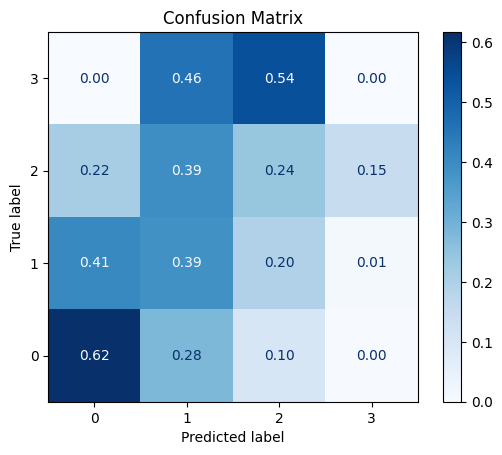

In [12]:
actual_dangers = pd.read_csv("../../data/2526_FAC/FAC_danger_levels_25.csv")

zone_map = {
    "whitefish range":"whitefish",
    "swan range":"swan",
    "flathead range & glacier np":"flathead"
}

actual_dangers['date'] = pd.to_datetime(actual_dangers['date'])
actual_dangers['zone_name'] = actual_dangers['zone_name'].apply(lambda x: zone_map[x])

curr_dff = pd.read_csv("../../data/ops25_26/new_all_predictions.csv").drop(columns=["predicted_danger"]).rename(columns={"date":"timestamp"})

val_x, val_y, val_excluded_cols = prep_data(
    curr_dff, 
    actual_dangers, 
    coords_geodf,
    replace_missing=True, 
    change_danger=False,
    exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 
val_y = val_y - 1
eval_model(val_y, xg.predict(val_x), plot=True, norm=True)

In [34]:
print(xg.get_params())


{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 42
#     }

space = {
    'eta': hp.choice('eta', [0.1, 0.3, 0.5]),
    'gamma': hp.choice('gamma', [0, 2, 4, 6, 8]),
    'max_depth': hp.choice('max_depth', [6, 25, 50]),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'max_delta_step': hp.choice('max_delta_step', [0, 2, 6]),
    'subsample': hp.choice('subsample', [0.5, 1]),
    'lambda': hp.uniform('reg_lambda', 0, 1),
    'alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'tree_method': hp.choice('tree_method', ['auto'])
}

def objective(space):
    # clf=xgb.XGBClassifier(
    #                 n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
    #                 reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
    #                 colsample_bytree=int(space['colsample_bytree']))
    
    clf=xgb.XGBClassifier(
                    eta=space['eta'],
                    gamma=space['gamma'],
                    max_depth=space['max_depth'],
                    min_child_weight=space['min_child_weight'],
                    max_delta_step=space['max_delta_step'],
                    subsample=space['subsample'],
                    reg_lambda=space['lambda'],
                    alpha=space['alpha'],
                    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.5134283570892724                                     
SCORE:                                                                            
0.6298574643660915                                                                
SCORE:                                                                            
0.5435858964741185                                                                
SCORE:                                                                            
0.6267066766691672                                                                
SCORE:                                                                            
0.6340585146286571                                                                
SCORE:                                                                            
0.6246061515378845                                                                
SCORE:                                                    

In [30]:
best_hyperparams

{'eta': np.int64(2),
 'gamma': np.int64(0),
 'max_delta_step': np.int64(0),
 'max_depth': np.int64(1),
 'min_child_weight': np.float64(6.0),
 'reg_alpha': np.float64(41.0),
 'reg_lambda': np.float64(0.6039745801964572),
 'subsample': np.int64(1),
 'tree_method': np.int64(0)}